In [1]:
%load_ext autoreload
%autoreload 2

import time, json
from datetime import datetime
import os

from stochastic_service_composition.services import build_service_from_transitions, Service
from stochastic_service_composition.target import build_target_from_transitions
from stochastic_service_composition.dfa_target import mdp_from_dfa
from stochastic_service_composition.declare_utils import *
from stochastic_service_composition.composition_mdp import composition_mdp
from stochastic_service_composition.composition_mdp import comp_mdp
from stochastic_service_composition.dfa_target import from_symbolic_automaton_to_declare_automaton

from docs.notebooks.utils import render_mdp_dfa
import logaut
import pylogics.parsers.ldl
from mdp_dp_rl.algorithms.dp.dp_analytic import DPAnalytic

def target_service_ltlf(constraints, symbols):
    constraints.append(build_declare_assumption(symbols))
    formula_str = " & ".join(map(lambda s: f"({s})", constraints))
    formula = pylogics.parsers.parse_ltl(formula_str)
    automaton = logaut.core.ltl2dfa(formula, backend="lydia")
    declare_automaton = from_symbolic_automaton_to_declare_automaton(automaton, symbols)
    return declare_automaton

### Actions definition

In [4]:
PICK_DESIGN = "p_d"
PICK_SILICON = "p_s"
PICK_IMPURITIES = "p_i"
PICK_RESIST = "p_r"
PICK_CHEMICALS = "p_c"
MASK_CREATION = "cr_m"
PHOTOLITOGRAPHY = "ph_l"
ETCHING = "et"
DEPOSITION = "dep"
ION_IMPLANTATION = "ion_i"
PROCESSING = "proc"
TESTING = "tes"
TESTING_GRAPHICS = "tes_gr"
QUALITY = "qual"
QUALITY_GRAPHICS = "qual_gr"
DICING = "dic"
CLASSIC_PACKAGING = "pac"  
THERMAL_PACKAGING = "pac_t"

#### Symbols

In [7]:
ALL_SYMBOLS = [
    PICK_DESIGN,
    PICK_SILICON,
    PICK_IMPURITIES,
    PICK_RESIST,
    PICK_CHEMICALS,
    MASK_CREATION,
    PHOTOLITOGRAPHY,
    ETCHING,
    ION_IMPLANTATION,
    TESTING,
    TESTING_GRAPHICS,
    DICING,
    CLASSIC_PACKAGING,
    THERMAL_PACKAGING
]

ALL_SYMBOLS_SET = set(ALL_SYMBOLS)

### Case 1

In [8]:
# declare process specification
declare_constraints = [
    exactly_once(PICK_DESIGN),
    exactly_once(PICK_SILICON),
    exactly_once(PICK_IMPURITIES),
    exactly_once(PICK_RESIST),
    exactly_once(PICK_CHEMICALS),
    exactly_once(MASK_CREATION),
    exactly_once(PHOTOLITOGRAPHY),
    exactly_once(ETCHING),
    exactly_once(ION_IMPLANTATION),
    exactly_once(DICING),
    
    absence_2(TESTING),
    absence_2(TESTING_GRAPHICS),
    absence_2(THERMAL_PACKAGING),
    absence_2(CLASSIC_PACKAGING),
    
    alt_succession(PICK_DESIGN, MASK_CREATION),
    alt_succession(PICK_SILICON, MASK_CREATION),
    alt_succession(PICK_IMPURITIES, MASK_CREATION),
    alt_succession(PICK_RESIST, MASK_CREATION),
    alt_succession(PICK_CHEMICALS, MASK_CREATION),
    
    alt_succession(MASK_CREATION, PHOTOLITOGRAPHY),
    alt_succession(PHOTOLITOGRAPHY, ETCHING),
    alt_succession(ETCHING, ION_IMPLANTATION),
    
    alt_precedence(ION_IMPLANTATION, TESTING),
    alt_precedence(ION_IMPLANTATION, TESTING_GRAPHICS),
    
    alt_response(TESTING, DICING),
    alt_response(TESTING_GRAPHICS, DICING),
    precedence_or(TESTING, TESTING_GRAPHICS, DICING),
    
    alt_precedence(DICING, CLASSIC_PACKAGING),
    alt_precedence(DICING, THERMAL_PACKAGING),
    
    not_coexistence(TESTING, TESTING_GRAPHICS),
    not_coexistence(QUALITY, QUALITY_GRAPHICS),
    not_coexistence(CLASSIC_PACKAGING, THERMAL_PACKAGING),
    
    build_declare_assumption(ALL_SYMBOLS_SET)
]

In [ ]:
declare_automaton = target_service_ltlf(declare_constraints, ALL_SYMBOLS_SET)
render_mdp_dfa(mdp_from_dfa(declare_automaton), no_sink=True)

### Case 2

In [2]:
# actions terms
PICK_DESIGN = "p_d"
PICK_SILICON = "p_s"
PICK_IMPURITIES = "p_i"
PICK_RESIST = "p_r"
PICK_CHEMICALS = "p_c"

MASK_CREATION = "cr_m"
PHOTOLITOGRAPHY = "ph_l"
ION_IMPLANTATION = "ion_i"

TESTING = "tes"
TESTING_QUALITY = "tes_qua"

QUALITY = "qua"

DICING = "dic"

CLASSIC_PACKAGING = "pac"  
THERMAL_PACKAGING = "pac_t"     #for cooling of GPU

In [3]:
ALL_SYMBOLS = [
    PICK_DESIGN,
    PICK_SILICON,
    PICK_IMPURITIES,
    PICK_RESIST,
    PICK_CHEMICALS,
    MASK_CREATION,
    PHOTOLITOGRAPHY,
    ION_IMPLANTATION,
    TESTING,
    TESTING_QUALITY,
    QUALITY,
    DICING,
    CLASSIC_PACKAGING,
    THERMAL_PACKAGING
]

ALL_SYMBOLS_SET = set(ALL_SYMBOLS)

In [4]:
# declare process specification
declare_constraints = [
    exactly_once(PICK_DESIGN),
    exactly_once(PICK_SILICON),
    exactly_once(PICK_IMPURITIES),
    exactly_once(PICK_RESIST),
    exactly_once(PICK_CHEMICALS),
    exactly_once(MASK_CREATION),
    exactly_once(PHOTOLITOGRAPHY),
    exactly_once(ION_IMPLANTATION),
    exactly_once(DICING),
    
    absence_2(TESTING),
    absence_2(TESTING_QUALITY),
    absence_2(QUALITY),
    absence_2(THERMAL_PACKAGING),
    absence_2(CLASSIC_PACKAGING),
    
    alt_succession(PICK_DESIGN, MASK_CREATION),
    alt_succession(PICK_SILICON, MASK_CREATION),
    alt_succession(PICK_IMPURITIES, MASK_CREATION),
    alt_succession(PICK_RESIST, MASK_CREATION),
    alt_succession(PICK_CHEMICALS, MASK_CREATION),
    
    alt_succession(MASK_CREATION, PHOTOLITOGRAPHY),
    alt_succession(PHOTOLITOGRAPHY, ION_IMPLANTATION),
    
    alt_precedence(ION_IMPLANTATION, TESTING),
    alt_precedence(ION_IMPLANTATION, TESTING_QUALITY),

    alt_succession(TESTING_QUALITY, QUALITY),
    
    alt_response(TESTING, DICING),
    alt_response(QUALITY, DICING),
    precedence_or(TESTING, QUALITY, DICING),
    
    alt_precedence(DICING, CLASSIC_PACKAGING),
    alt_precedence(DICING, THERMAL_PACKAGING),
    
    not_coexistence(TESTING, TESTING_QUALITY),
    not_coexistence(CLASSIC_PACKAGING, THERMAL_PACKAGING),
    
    build_declare_assumption(ALL_SYMBOLS_SET)
]

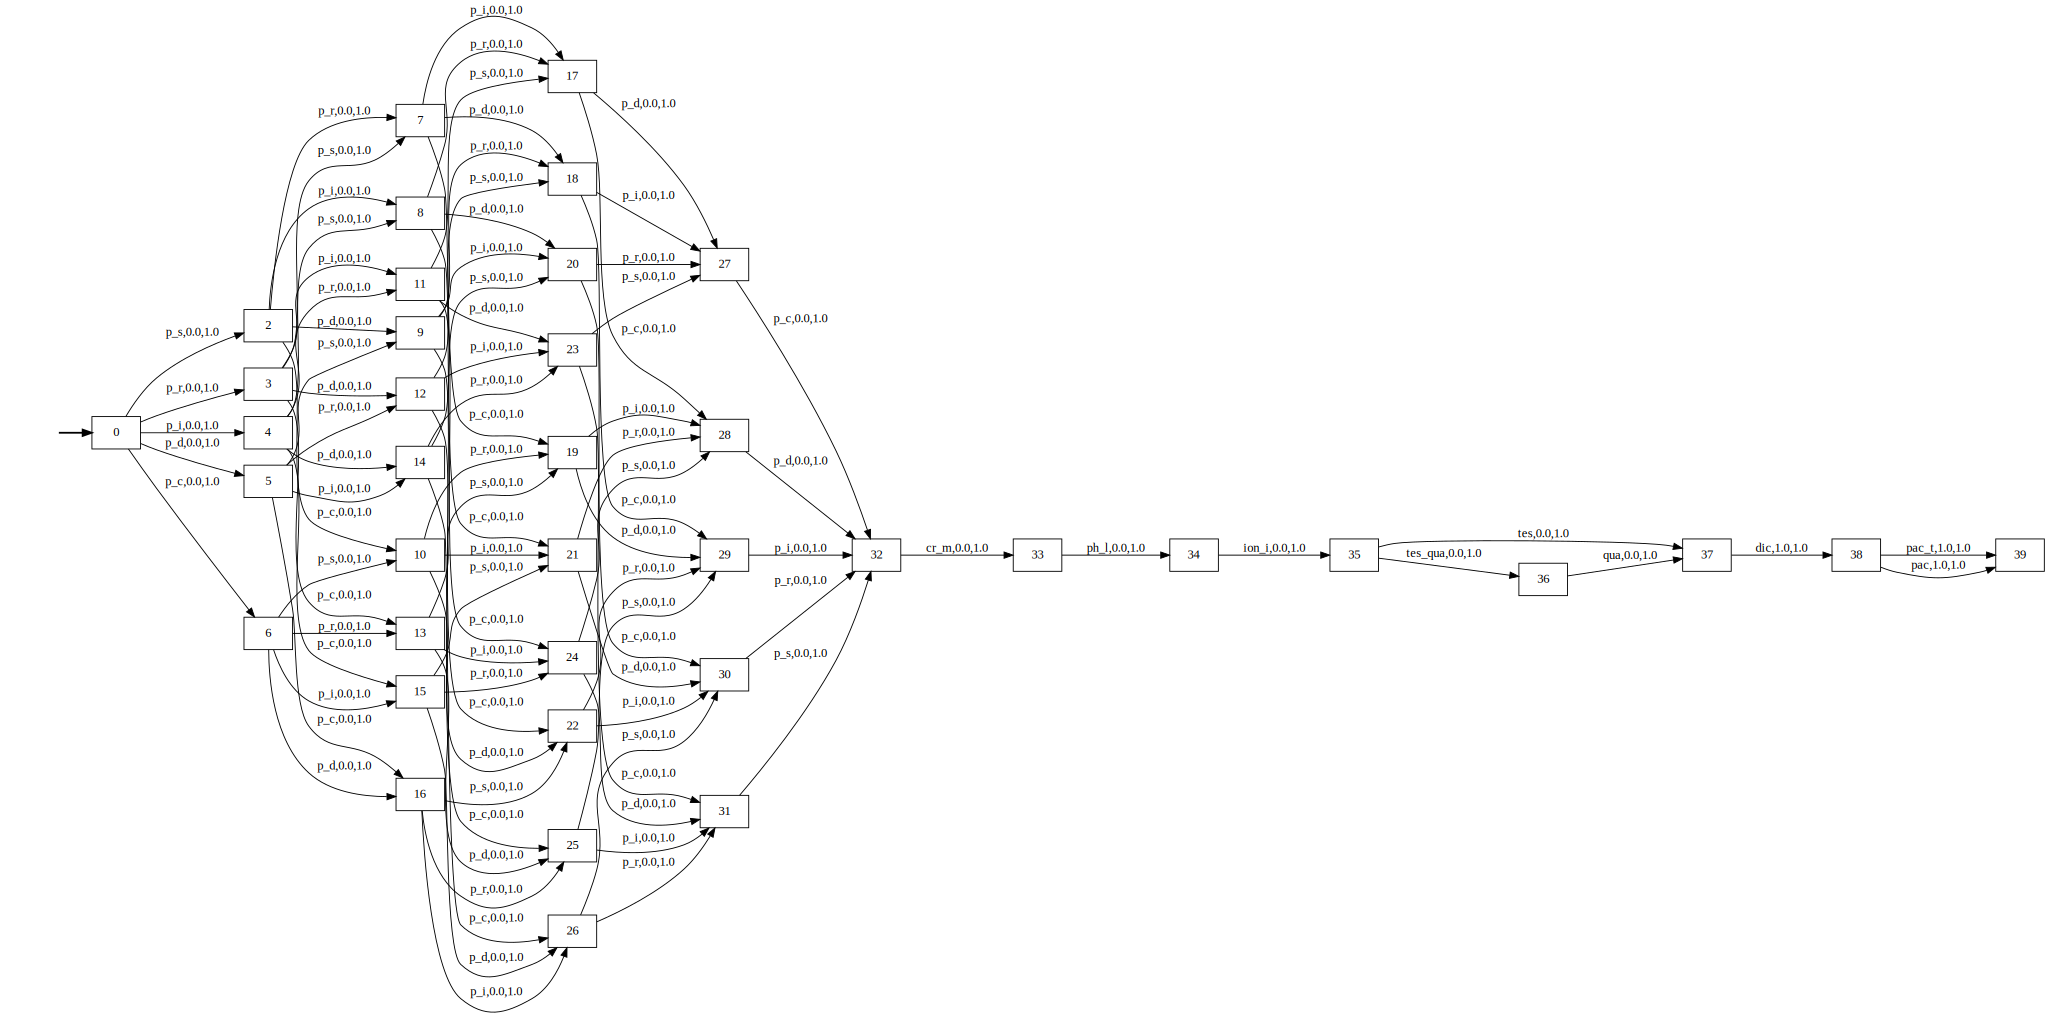

In [5]:
declare_automaton = target_service_ltlf(declare_constraints, ALL_SYMBOLS_SET)
render_mdp_dfa(mdp_from_dfa(declare_automaton), no_sink=True)

In [7]:
from stochastic_service_composition.rendering import mdp_to_graphviz
digraph = mdp_to_graphviz(mdp_from_dfa(declare_automaton), no_sink=True)

In [12]:
from graphviz import Digraph
digraph.render(filename="prova.dot")

'prova.dot.svg'